Import libraries for fetching the data

In [1]:
import os
import pandas as pd
import timeit
import rpy2.robjects as ro
from rpy2.robjects import r
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
import requests


Unable to determine R home: [WinError 2] Den angivne fil blev ikke fundet
Unable to determine R library path: Command '('C:\\Program Files\\R\\R-4.1.2\\bin\\Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.


Fetch and convert cipher data to pandas dataframe.

In [2]:
data_url = "https://nextcloud.sdu.dk/index.php/s/Zzjcqjopy5cTawn/download/data_33.Rdata"
data_file = "data.Rdata"

#download the file
req = requests.get(data_url, allow_redirects=True, stream=True)

#save downloaded file
with open(data_file,"wb") as rf:
     for chunk in req.iter_content(chunk_size=1024):
         # writing one chunk at a time to r file
         if chunk:
              rf.write(chunk)

r_data=r.load(data_file)

with localconverter(ro.default_converter + pandas2ri.converter):
    ciphers = ro.conversion.rpy2py(r['ciphers'])

Define utility functions.

In [71]:
import numpy as np
import random
import statistics
from stopwatch import Stopwatch
import matplotlib.pyplot as plt
import seaborn as sn

In [35]:
def take(arr, indexes):
    mask = np.ones(len(arr), dtype=bool)
    mask[indexes] = True
    return arr[mask]

def take_inverse(arr, indexes):
    mask = np.ones(len(arr), dtype=bool)
    mask[indexes] = False
    return arr[mask]

def all_persons_in(ciphers, split = 0.5):
    count = len(ciphers)
    samples = random.sample(range(0, count), int(count * split))
    train_data = take(ciphers, samples)
    test_data = take_inverse(ciphers, samples)
    return { "train_data": train_data, "test_data": test_data }

def disjunct(ciphers, amount):
    total_people = len(set(ciphers.T[0]))
    per_person = int(len(ciphers) / total_people)
    train_data = take(ciphers, range(0, per_person * amount))
    test_data = take_inverse(ciphers, range(0, per_person * amount))
    return { "train_data": train_data, "test_data": test_data }

def split(ciphers):
    person_index = ciphers.T[0]
    ground_truth = ciphers.T[1]
    data = []
    for cipher in ciphers:
        data.append(cipher[2:len(cipher)])
    return { "person": person_index, "truth":ground_truth, "data": data}

def compute_accuracy_folds(folds, ciphers, predictor, predictor_args = {}):
    results = []
    for fold in folds:
        train_raw = split(take_inverse(ciphers, fold))
        test_raw = split(take(ciphers, fold))

        train_data = train_raw['data']
        train_labels = train_raw['truth']
        test_data = test_raw['data']
        test_labels = test_raw['truth']

        predictions = predictor(train_data, train_labels, test_data, predictor_args)
        cf = pd.crosstab(predictions, test_labels)
        accuracy = np.diag(cf).sum() / cf.to_numpy().sum()

        results.append(accuracy)

    mean = statistics.mean(results)
    stdev = statistics.stdev(results)
    return { "mean": mean, "stdev": stdev }

def k_folds(arr_size, folds):
    samples = range(0, arr_size)
    return np.array_split(samples, folds)

Perform PCA and other preprocessing on ciphers.

In [29]:
shuffle = random.sample(range(0, len(ciphers)), len(ciphers))
ciphers_shuffle = take(ciphers, shuffle)

In [30]:
from sklearn.decomposition import PCA

def decompose(ciphers, cumsum):
    cipher_length = len(ciphers.T)

    metadata = np.delete(ciphers, range(2, cipher_length), axis=1)
    copy = np.delete(ciphers, [0,1], axis=1)

    pca = PCA(cumsum)
    pca.fit(copy)
    transformed = pca.transform(copy)

    ciphers_pca = np.append(metadata, transformed, axis=1)
    return ciphers_pca

ciphers_pca = decompose(ciphers, 0.8)
ciphers_shuffle_pca = decompose(ciphers_shuffle, 0.8)

Perform cross-validated kNN analysis with and without preprocessing

In [6]:
from sklearn.neighbors import KNeighborsClassifier

# kNN functions
def knn_predictor(train_data, train_labels, test_data, args):
    k = args['k']
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(train_data, train_labels)
    return neigh.predict(test_data)

In [26]:
# Without preprocessing
data = all_persons_in(ciphers, 0.5)
print(compute_accuracy_folds(k_folds(66000, 10), ciphers, knn_predictor, {'k': 3}))

{'mean': 0.9340454545454545, 'stdev': 0.00043199307815894913}


In [37]:
stopwatch = Stopwatch(True)
print(compute_accuracy_folds(k_folds(66000, 10), ciphers_pca, knn_predictor, {'k': 3}))
stopwatch.end_and_print()

stopwatch.start()
print(compute_accuracy_folds(k_folds(66000, 10), ciphers_shuffle_pca, knn_predictor, {'k': 3}))
stopwatch.end_and_print()

{'mean': 0.9400439393939394, 'stdev': 0.0038590317183834475}
Time Lapsed = 0:0:35.17416024208069
{'mean': 0.9400439393939394, 'stdev': 0.0038590317183834475}
Time Lapsed = 0:0:35.68927025794983


35.68927025794983

0.958939393939394


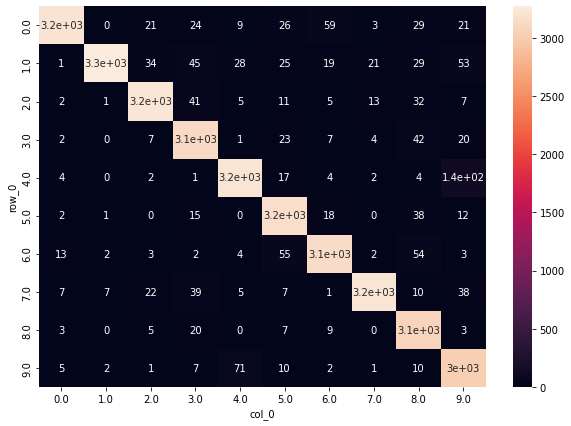

In [77]:
data = all_persons_in(ciphers_pca)
predictions = knn_predictor(data["train_data"][:, 2:], data["train_data"][:,1], data["test_data"][:, 2:], {'k': 3})
cf = pd.crosstab(predictions, data["test_data"][:, 1])
plt.figure(figsize=(10, 7))
sn.heatmap(cf, annot=True, categories = [c for c in "0123456789"])
accuracy = np.diag(cf).sum() / cf.to_numpy().sum()
print(accuracy)